In [22]:
# Add module path for demo.
# Todo: add setup file as pip install tsx
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from tsx.perturbation import TimeSeriesPerturbation
from tsx.xai.lime import LIMETimeSeries
from tsx.xai import evaluation as eva

WORK_DIR = ".."
DATA_DIR = f"{WORK_DIR}/tests/data"
assert os.path.exists(DATA_DIR), f"Not found folder {DATA_DIR}"

## Prepare Data Set

In [24]:
def load_data_set_bejin():
    data_link = f"{DATA_DIR}/pollution.csv"
    assert os.path.exists(data_link), f"Not found folder {data_link}"
    df = pd.read_csv(data_link)

    # Set date-time as index
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")

    return df

def get_instance_x(df):
    idx = np.random.randint(0, len(df.index) - 128 - 1)
    return df[idx:idx + 128].copy()

# Prepare data set
df = load_data_set_bejin()

# Encoding wind_direction to integer
encoder = LabelEncoder()
df["wind_direction"] = encoder.fit_transform(df["wind_direction"])

# Normalization
independents = ["dew", "temp", "press", "wind_direction", "wind_speed", "snow", "rain"]
dependent = "pollution"
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler.fit(df[independents].values)
y_scaler.fit(df[dependent].values.reshape(-1, 1))


# Prepare predict function
wavenet = tf.keras.models.load_model(f"{DATA_DIR}/wavenet_mts_128_1.h5")
lstm = tf.keras.models.load_model(f"{DATA_DIR}/lstm_mts_128_1.h5")


def predict_fn(z, model=lstm):
    z = z.reshape(1, 128, 7)
    z_hat = model.predict(z)
    z_hat = y_scaler.inverse_transform(z_hat.reshape(-1, 1))  # to avoid zero coef_ for z_hat in[0, 1]
    z_hat = z_hat.ravel()   # z_hat will arround 50 - 150
    return z_hat[0]

def lstm_predict_fn(z):
    return predict_fn(z, model=lstm)

def wavenet_predict_fn(z):
    return predict_fn(z, model=wavenet)

### Fitting the explaining model by using LIME Time Series

In [25]:
# 1- Load an instance
x = get_instance_x(df)
x[independents] = x_scaler.transform(x[independents].values)
ts_x = x[independents].values.reshape(7, 128)  # 7 features, 128 steps

# 2- Use LIME for Time Series with default for forecasting.
ts_lime_sync = LIMETimeSeries(scale="sync", window_size=4, sample_size=100)
ts_lime_async = LIMETimeSeries(scale="async", window_size=4, sample_size=100)

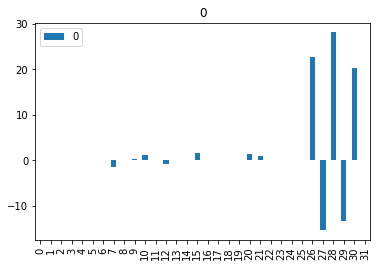

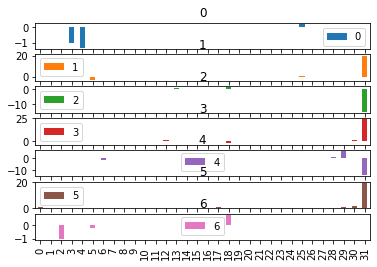

In [26]:
lstm_sync = ts_lime_sync.explain(ts_x, predict_fn=lstm_predict_fn)
lstm_async = ts_lime_async.explain(ts_x, predict_fn=lstm_predict_fn)
lstm_sync.plot_coef()
lstm_async.plot_coef()


In [45]:

ts_lime_zeros = LIMETimeSeries(scale="async", window_size=4, sample_size=100, perturb_method='zeros')
ts_lime_mean = LIMETimeSeries(scale="async" ,window_size=4, sample_size=100, perturb_method='local_mean')

lstm_zeros = ts_lime_zeros.explain(ts_x, predict_fn=lstm_predict_fn)
lstm_mean = ts_lime_mean.explain(ts_x, predict_fn=lstm_predict_fn)

wavenet_zeros = ts_lime_zeros.explain(ts_x, predict_fn=wavenet_predict_fn)
wavenet_mean = ts_lime_mean.explain(ts_x, predict_fn=wavenet_predict_fn)

models = [lstm_zeros, lstm_mean, wavenet_zeros, wavenet_mean]
names = ["lstm_zeros", "lstm_mean", "wavenet_zeros", "wavenet_mean"]

df_corr_async = eva.corr_matrix(models, names)
r2_scores_async = [lstm_zeros.score, lstm_mean.score, wavenet_zeros.score, wavenet_mean.score]


In [46]:
ts_lime_zeros = LIMETimeSeries(scale="sync", window_size=4, sample_size=100, perturb_method='zeros')
ts_lime_mean = LIMETimeSeries(scale="sync" ,window_size=4, sample_size=100, perturb_method='local_mean')

lstm_zeros = ts_lime_zeros.explain(ts_x, predict_fn=lstm_predict_fn)
lstm_mean = ts_lime_mean.explain(ts_x, predict_fn=lstm_predict_fn)

wavenet_zeros = ts_lime_zeros.explain(ts_x, predict_fn=wavenet_predict_fn)
wavenet_mean = ts_lime_mean.explain(ts_x, predict_fn=wavenet_predict_fn)

models = [lstm_zeros, lstm_mean, wavenet_zeros, wavenet_mean]
names = ["lstm_zeros", "lstm_mean", "wavenet_zeros", "wavenet_mean"]


df_corr_sync = eva.corr_matrix(models, names)
r2_scores_sync = [lstm_zeros.score, lstm_mean.score, wavenet_zeros.score, wavenet_mean.score]

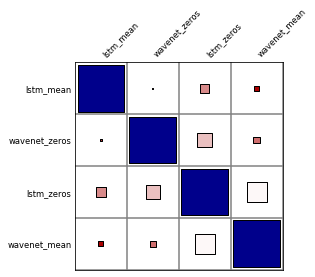

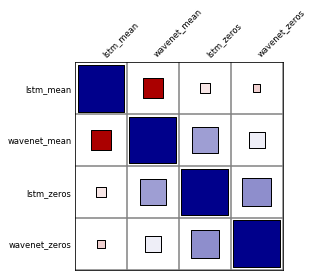

In [42]:
from biokit.viz import corrplot
c1 = corrplot.Corrplot(df_corr_async)
c2 = corrplot.Corrplot(df_corr_sync)

c1.plot(method='square', shrink=.9, rotation=45, colorbar=False)
c2.plot(method='square', shrink=.9, rotation=45, colorbar=False)

In [51]:
# Approximation Score
df = pd.DataFrame([r2_scores_sync, r2_scores_async], index=['sync', 'async'] )
df.columns = names
df

,lstm_zeros,lstm_mean,wavenet_zeros,wavenet_mean
sync,0.923189,0.802241,0.207562,0.498420
async,0.963628,0.794085,-0.565246,0.298054


<AxesSubplot:>

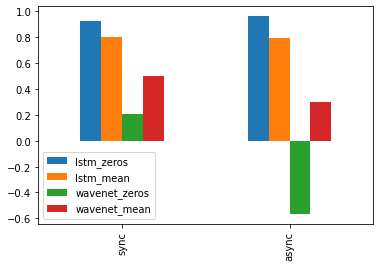

In [55]:
df.plot(kind='bar')